# Sensitivity Analyses for Means or Proportions with Missing Data

Paul Zivich (2023/01/24)

In [1]:
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.utilities import inverse_logit

# Ignore annoying warning about pandas.append depreciation
warnings.simplefilter(action='ignore', category=FutureWarning)

print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("Pandas:      ", pd.__version__)
print("Delicatessen:", deli.__version__)

NumPy:        1.22.2
SciPy:        1.9.2
Pandas:       1.4.1
Delicatessen: 1.1


## Loading data

In [2]:
d = pd.read_csv("lau_wihs.dat", sep="\s+",
                header=None, names=["id", "black", "age", "cd4", "cd41", "cd42", "cd43", "cd44"])

# Force CD4 to be numeric (errors=coerce is fine here)
#    The SAS '.' indicator for missing makes it object in pandas
#    but this causes issues later on down the line if not converted.
d['cd41'] = pd.to_numeric(d['cd41'], errors='coerce')
d['cd42'] = pd.to_numeric(d['cd42'], errors='coerce')
d['cd43'] = pd.to_numeric(d['cd43'], errors='coerce')
d['cd44'] = pd.to_numeric(d['cd44'], errors='coerce')

# Adding intercept / constant term to the data
d['intercept'] = 1

## Creating some helper functions
Defining the estimating equations for use with `delicatessen`. 

Note: the following estimating equation is abstracted to support both no-covariate (examples 1-2) and covariate (example 3) implementations.

In [3]:
def q_function(y_vals, alpha):
    return alpha*np.where(np.isnan(y_vals), 0, y_vals)


def ee_sensitivity_analysis(theta, delta, y, X, qy, bound_function):
    r"""Robins's sensitivity analysis as an estimating equation

    Parameters
    ----------
    theta : ndarray, list, vector
        Theta in this case consists of 1+b values. Therefore, initial values should consist of one plus the number of
        columns present in ``X``. This can easily be accomplished generally by ``[0, ] + [0, ] * X.shape[1]``.
    delta : ndarray, list, vector
        1-dimensional vector of n observed values indicating whether the observation has a value for ``y`` observed,
        where 1 indicates yes and 0 indicated no. No ``nan``'s / missing data should be included.
    y : ndarray, list, vector
        1-dimensional vector of n values. No missing data should be included. As ``y`` will actually be missing, generic
        values should be used to replace the ``nan`` observations for the optimization procedure. These placeholder
        values will be effectively ignored. For example, use ``y[1-delta] = -999``.
    X : ndarray, list, vector
        2-dimensional vector of n observed values for b variables consider as predictors. At a minimum, a vector of ones
        (the intercept) should be included. No missing data should be included.
    qy : ndarray, list, vector
        1-dimensional vector of n values of shifts in the model based on the :math:`q(Y; \alpha)` function. No missing
        data should occur.
    bound_function : function
        Function use to bound the observations. The function must be monotonic increasing and be bounded by 0,1. For
        example, the expit (inverse-logit) function meets this criteria.
    """
    delta = np.asarray(delta)[:, None]       # Convert to NumPy array and ensure correct shape for matrix algebra
    y = np.asarray(y)[:, None]               # Convert to NumPy array and ensure correct shape for matrix algebra
    X = np.asarray(X)                        # Convert to NumPy array
    qy = np.asarray(qy)[:, None]             # Convert to NumPy array and ensure correct shape for matrix algebra
    beta = np.asarray(theta[1:])[:, None]    # Convert to NumPy array and ensure correct shape for matrix algebra

    # Predicted values from design matrix and nuisance coefficients
    pred_values = np.dot(X, beta)            # dot product to get quickly (like regression)

    # Solving for the sensitivity analysis mean
    numerator = delta * y                                 # Numerator
    denominator = bound_function(pred_values + qy)        # Denominator
    mean = np.nan_to_num(numerator / denominator,         # Sensitivity analysis estimating equation
                         copy=False, nan=0.) - theta[0]   # ... and setting missing as zero's

    # Solving for intercept and coefficients of model
    h_params = (delta / bound_function(pred_values + qy) - 1)*X   # Multiply by X to keep dims the same
    
    # Returning stacked estimating equations
    return np.vstack((mean.T,       # theta[0] is the sensitivity analysis mean
                      h_params.T))  # theta[1:] is (are) the nuisance parameter(s)

## Example 1: Mean CD4 cell count

In [4]:
def psi(theta):
    # Specify estimating equation for delicatessen
    return ee_sensitivity_analysis(theta=theta,   # Passing parameters forward
                                   delta=delta,   # Indicator of missing
                                   y=y,           # Variable of interest
                                   X=X,           # Intercept-only design matrix
                                   # The q function used in the paper
                                   qy=q_function(y_vals=y, alpha=alpha),
                                   # The H function used in the paper
                                   bound_function=inverse_logit)

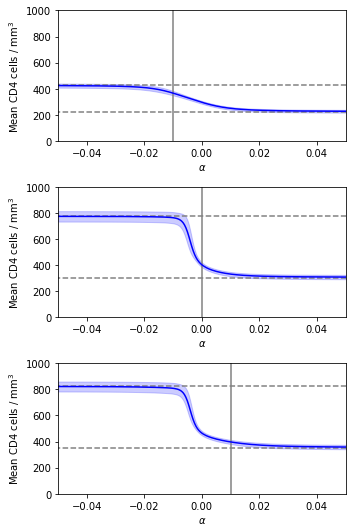

In [5]:
# Setting up parts to generate the figure
plot_ids = [311, 312, 313]       # Plot IDs (3 stacked plots)
plt.figure(figsize=[5, 7.5])     # Figure size to use

# Looping over the 3 scenarios
for ids in plot_ids:
    # Loading the corresponding outcome for the scenario
    if ids == 311:
        y = np.asarray(d['cd43'])
        true_alpha = -0.01
    elif ids == 312:
        y = np.asarray(d['cd41'])
        true_alpha = 0.0
    elif ids == 313:
        y = np.asarray(d['cd42'])
        true_alpha = 0.01
    else:
        raise ValueError("Invalid plot_ids")

    # Extracting to NumPy arrays for delicatessen
    delta = np.where(np.isnan(y), 0, 1)   # Creating missing indicator
    X = np.asarray(d[['intercept']])      # Intercept-only design matrix
    
    # Calculating the corresponding upper and lower bounds for plot
    y_upper = np.mean(np.where(delta == 0, np.nanmax(y), y))
    y_lower = np.mean(np.where(delta == 0, np.nanmin(y), y))

    # Storage for sensitivity analysis results
    results = pd.DataFrame(columns=['alpha', 'estimate', 'lcl', 'ucl'])

    # Conducting sensitivity analysis
    #   (working out from center to the extremes for init vals)
    alphas = np.linspace(0, 0.05, 100)   # Upper range of alphas
    prev_optim = [0., 0.]                # Init storage for previous loop values
    for alpha in alphas:
        # Solve the current M-estimator
        mest = MEstimator(psi, init=prev_optim)
        mest.estimate(solver='lm')
        # Store current theta as the starting values of root-finding for next loop
        prev_optim = mest.theta
        # Store the results in the storage data frame
        results = results.append({'alpha': alpha,
                                  'estimate': mest.theta[0],
                                  'lcl': mest.confidence_intervals()[0][0],
                                  'ucl': mest.confidence_intervals()[0][1]},
                                 ignore_index=True)
    
    alphas = np.linspace(0, -0.05, 100)  # Repeating for lower range of alphas
    prev_optim = [0., 0.]                # Init storage for previous loop values
    for alpha in alphas:
        # Solve the current M-estimator
        mest = MEstimator(psi, init=prev_optim)
        mest.estimate(solver='lm')
        # Store current theta as the starting values of root-finding for next loop
        prev_optim = mest.theta
        # Store the results in the storage data frame
        results = results.append({'alpha': alpha,
                                  'estimate': mest.theta[0],
                                  'lcl': mest.confidence_intervals()[0][0],
                                  'ucl': mest.confidence_intervals()[0][1]},
                                 ignore_index=True)

    # Sorting results by alpha for plotting step
    results = results.sort_values(by='alpha', ignore_index=True)
    # Force-convert to numeric to prevent any issues in plotting
    for c in results.columns:
        results[c] = pd.to_numeric(results[c])
    
    # Create the corresponding sub-plot
    plt.subplot(ids)
    plt.hlines(y_upper, -0.5, 0.5, colors='gray', linestyles='--')
    plt.hlines(y_lower, -0.5, 0.5, colors='gray', linestyles='--')
    plt.vlines(true_alpha, 0, 1000, colors='gray', linestyles='-')
    plt.fill_between(results['alpha'], results['lcl'], results['ucl'],
                     color='blue', alpha=0.2)
    plt.plot(results['alpha'], results['estimate'], '-', color='blue')
    plt.ylim([0, 1000])
    plt.ylabel(r"Mean CD4 cells / mm$^3$")
    plt.xlim([-0.05, 0.05])
    plt.xlabel(r"$\alpha$")


plt.tight_layout()

## Example 2: Proportion of CD4 counts below 200 cells/mm$^3$

In [6]:
def psi(theta):
    # Specify estimating equation for delicatessen
    return ee_sensitivity_analysis(theta=theta,   # Passing parameters forward
                                   delta=delta,   # Indicator of missing
                                   y=y_bin,       # Variable of interest (binary)
                                   X=X,           # Intercept-only design matrix
                                   # The q function used in the paper
                                   qy=q_function(y_vals=y, alpha=alpha),
                                   # The H function used in the paper
                                   bound_function=inverse_logit)

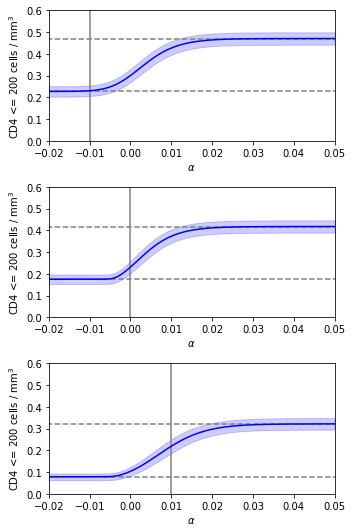

In [7]:
# Setting up parts to generate the figure
plot_ids = [311, 312, 313]       # Plot IDs (3 stacked plots)
plt.figure(figsize=[5, 7.5])     # Figure size to use

# Looping over the 3 scenarios
for ids in plot_ids:
    # Loading the corresponding outcome for the scenario
    if ids == 311:
        y = np.asarray(d['cd43'])
        true_alpha = -0.01
    elif ids == 312:
        y = np.asarray(d['cd41'])
        true_alpha = 0.0
    elif ids == 313:
        y = np.asarray(d['cd42'])
        true_alpha = 0.01
    else:
        raise ValueError("Invalid plot_ids")

    # Extracting to NumPy arrays for delicatessen
    delta = np.where(np.isnan(y), 0, 1)  # Missing data indicator
    X = np.asarray(d[['intercept']])     # Intercept-only design matrix
    y_bin = np.where(y <= 200., 1, 0)    # Binary conversion of outcome

    # Calculating the corresponding upper and lower bounds for plot
    y_upper = np.mean(np.where((delta == 0) + (y <= 200.), 1, 0))
    y_lower = np.mean(np.where((delta == 1) * (y <= 200.), 1, 0))

    # Storage for sensitivity analysis results
    results = pd.DataFrame(columns=['alpha', 'estimate', 'lcl', 'ucl'])

    # Conducting sensitivity analysis
    #   (working out from center to the extremes for init vals)
    alphas = np.linspace(0, 0.05, 100)  # Upper range of alphas
    prev_optim = [0., 0.]               # Init storage for previous loop values
    for alpha in alphas:
        # Solve the current M-estimator
        mest = MEstimator(psi, init=prev_optim)
        mest.estimate(solver='lm')
        # Store current theta as the starting values of root-finding for next loop
        prev_optim = mest.theta
        # Store the results in the storage data frame
        results = results.append({'alpha': alpha,
                                  'estimate': mest.theta[0],
                                  'lcl': mest.confidence_intervals()[0][0],
                                  'ucl': mest.confidence_intervals()[0][1]},
                                 ignore_index=True)

    alphas = np.linspace(0, -0.02, 100)  # Lower range of alphas
    prev_optim = [0., 0.]                # Init storage for previous loop values
    for alpha in alphas:
        # Solve the current M-estimator
        mest = MEstimator(psi, init=prev_optim)
        mest.estimate(solver='lm')
        # Store current theta as the starting values of root-finding for next loop
        prev_optim = mest.theta
        # Store the results in the storage data frame
        results = results.append({'alpha': alpha,
                                  'estimate': mest.theta[0],
                                  'lcl': mest.confidence_intervals()[0][0],
                                  'ucl': mest.confidence_intervals()[0][1]},
                                 ignore_index=True)

    # Sorting results by alpha for plot
    results = results.sort_values(by='alpha', ignore_index=True)
    # Force-convert to numeric to prevent any issues in plotting
    for c in results.columns:
        results[c] = pd.to_numeric(results[c])
    
    # Create corresponding sub-plot
    plt.subplot(ids)
    plt.hlines(y_upper, -6, 6, colors='gray', linestyles='--')
    plt.hlines(y_lower, -6, 6, colors='gray', linestyles='--')
    plt.vlines(true_alpha, 0, 0.6, colors='gray', linestyles='-')
    plt.fill_between(results['alpha'], results['lcl'], results['ucl'],
                     color='blue', alpha=0.2)
    plt.plot(results['alpha'], results['estimate'], '-', color='blue')
    plt.ylim([0, 0.6])
    plt.ylabel(r"CD4 <= 200 cells / mm$^3$")
    plt.xlim([-0.02, 0.05])
    plt.xlabel(r"$\alpha$")


plt.tight_layout()

## Example 3: Proportion of CD4 counts below 200 cells/mm$^3$ with observed covariates

In [8]:
def psi(theta):
    # Specify estimating equation for delicatessen
    return ee_sensitivity_analysis(theta=theta,   # Passing parameters forward
                                   delta=delta,   # Indicator of missing
                                   y=y_bin,       # Variable of interest (binary)
                                   X=X,           # Design matrix with covariates
                                   # The q function used in the paper
                                   qy=q_function(y_vals=y, alpha=alpha),
                                   # The H function used in the paper
                                   bound_function=inverse_logit)

In [9]:
# Formatting variables for delicatessen
delta = np.where(d['cd44'].isna(), 0, 1)            # Indicator of missingness
y = np.asarray(d['cd44'])                           # Outcome array
y_bin = np.where(y <= 200., 1, 0)                   # Converting to binary indicator
d['age30'] = np.where(d['age'] <= 30, 0, 1)         # Categorizing age
X = np.asarray(d[['intercept', 'age30', 'black']])  # Design matrix

In [10]:
# Calculating the corresponding upper and lower bounds for plot
y_upper = np.mean(np.where(delta == 0, 0, y_bin))
y_lower = np.mean(np.where(delta == 0, 1, y_bin))

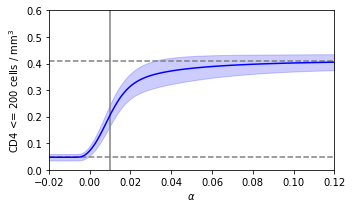

In [11]:
# Storage for sensitivity analysis results
results = pd.DataFrame(columns=['alpha', 'estimate', 'lcl', 'ucl'])

# Conducting sensitivity analysis
#   (working out from center to the extremes for init vals)
alphas = np.linspace(0, 0.12, 100)   # Upper range of alphas
prev_optim = [0., 0., 0., 0.]        # Init storage for previous loop values
for alpha in alphas:
    # Solve the current M-estimator
    mest = MEstimator(psi, init=prev_optim)
    mest.estimate(solver='lm')
    # Store current theta as the starting values of root-finding for next loop
    prev_optim = mest.theta
    # Store the results in the storage data frame
    results = results.append({'alpha': alpha,
                              'estimate': mest.theta[0],
                              'lcl': mest.confidence_intervals()[0][0],
                              'ucl': mest.confidence_intervals()[0][1]},
                             ignore_index=True)

alphas = np.linspace(0, -0.02, 20)   # Lower range of alphas
prev_optim = [0., 0., 0., 0.]        # Init storage for previous loop values
for alpha in alphas:
    # Solve the current M-estimator
    mest = MEstimator(psi, init=prev_optim)
    mest.estimate(solver='lm')
    # Store current theta as the starting values of root-finding for next loop
    prev_optim = mest.theta
    # Store the results in the storage data frame
    results = results.append({'alpha': alpha,
                              'estimate': mest.theta[0],
                              'lcl': mest.confidence_intervals()[0][0],
                              'ucl': mest.confidence_intervals()[0][1]},
                             ignore_index=True)

# Sorting results by alpha for plot
results = results.sort_values(by='alpha')
for c in results.columns:
    results[c] = pd.to_numeric(results[c])

# Plotting results
plt.figure(figsize=[5, 7.5 / 2.5])
plt.hlines(y_upper, -0.02, 0.12, colors='gray', linestyles='--')
plt.hlines(y_lower, -0.02, 0.12, colors='gray', linestyles='--')
plt.vlines(0.01, 0, 0.6, colors='gray', linestyles='-')
plt.fill_between(results['alpha'], results['lcl'], results['ucl'],
                 color='blue', alpha=0.2)
plt.plot(results['alpha'], results['estimate'], '-', color='blue')
plt.ylim([0, 0.6])
plt.ylabel(r"CD4 <= 200 cells / mm$^3$")
plt.xlim([-0.02, 0.12])
plt.xlabel(r"$\alpha$")

plt.tight_layout()

END